# Interpreting ML models for Diabetes Patient Readmission <a id='intro'></a>

*All information regarding the features and dataset can be found in this research arcticle:
**<br/> [Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records](https://storage.googleapis.com/kaggle-datasets/3724/5903/description.pdf?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1551405064&Signature=IOvPPYOQDNHjMQAXz8CR%2FW5L6sk39s5MAuvQyCOcIupZGOBwil4MMkA0DTwvr79iK2TSPznn5eiUxxJydgWE%2FJuNTRiqH%2BKYE%2BMNorDxw292LNlaf5s7p6G4jo9Q8wzkWlSfkb7OrUd%2FEMjjtqYb8tE1oE4s6m8GI8tUZKDHeFr3hyUtusiiDB6wg7qt521wlEPfv%2FXgJeJTxQf5JrQvQ%2FrawREtN4YYTVcNpEy4U7lVREladf4hURIH7OZEPTfepViUC4RnZ37zdBvgBRR4hkpeE6Y7MMZig3heZRfQxk54PwxJcIwV%2FPtxz4topFBDQ6M1L3i5RqGAbNmo2UoEOQ%3D%3D)***

I personally have a family history of diabetes so I want to know how different features affect the diabetes in general.
<br/> For this kernel, we will be using a diabates readmission datset to explore the different frameworks for model explainability

<br/> Machine learning models that can be used in the medical field should be interpretable.
<br/> Humans should know why these models decided on a conclusion.
<br/> The problem is the more complex a ML model gets the less interpretable it gets.
<br/>In this kernel we will examine techniques and frameworks in interpreting ML models.

See Worldwide Diabetes Statistics below: 
![](http://everydaydiabetes.com/wp-content/uploads/Diabetes-Statistics-Worldwide-Everyday-Diabetes.jpg)

### Table of Contents
- [Data Preprocessing](#dp)
- [Modeling](#model)
    - Logistic Regression
    - Random Forest
    - Neural Network
- [Model Interpretability Frameworks](#interp)
    - [LIME](#LIME)
    - [ELI5](#ELI5)
    - [SHAP](#SHAP)
    - [SKATER](#SKATER)
- [Summary](#summ)
- [Key Takeaways](#conc)

In [1]:
# data pre processing
import numpy as np
import pandas as pd

# data visuzlization
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score

# model explainers
import lime
from lime.lime_tabular import LimeTabularExplainer

import eli5
from eli5.sklearn import PermutationImportance

import shap
from shap import TreeExplainer,KernelExplainer,LinearExplainer
shap.initjs()

!conda install -c conda-forge Skater -y
import skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import warnings
warnings.filterwarnings('ignore')

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

## **Data Preprocessing** <a  id='dp'></a>
<br/> This section will cover data exploration and feature engineering.
<br/> Majority of the features created was inspired by [K-fold CV using xgboost by Humberto Brandão](https://www.kaggle.com/brandao/k-fold-cv-using-xgboost-auc-0-7153)
<br/> The rest were adapted from the research article mentioned in the [introduction](#intro)

In [2]:
df = pd.read_csv('../input/diabetic_data.csv')
df.replace('?',np.nan,inplace=True)
df.head()

encounter_id  patient_nbr    ...     diabetesMed readmitted
0       2278392      8222157    ...              No         NO
1        149190     55629189    ...             Yes        >30
2         64410     86047875    ...             Yes         NO
3        500364     82442376    ...             Yes         NO
4         16680     42519267    ...             Yes         NO

[5 rows x 50 columns]

As we can see above the dataset contains several numerical and categorical variables that we need to process
<br/> First we need to check if the how many data points contains missing values

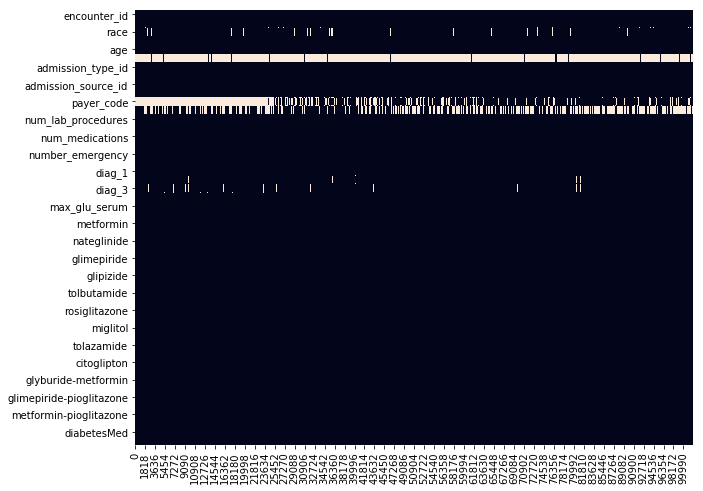

In [3]:
plt.figure(figsize=(10,8))
sns.heatmap(df.isnull().T, cbar=False)

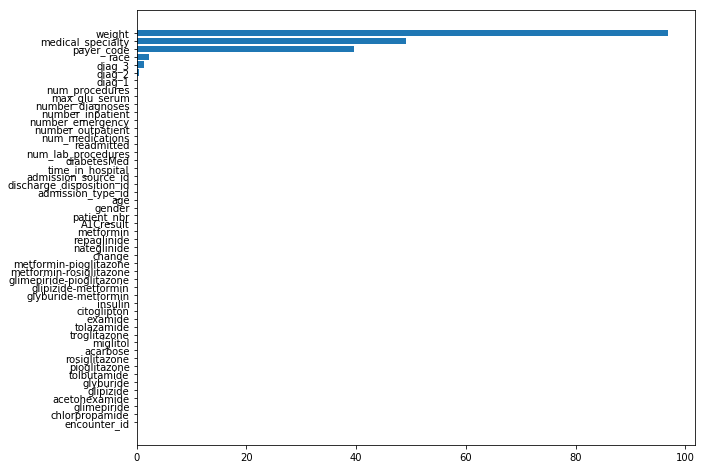

In [4]:
plt.figure(figsize=(10,8))
missing = pd.DataFrame({'column':df.columns ,'na_percent':df.isnull().sum()/len(df)*100})
missing.sort_values('na_percent',inplace=True)
plt.barh(missing['column'],width=missing['na_percent']);

In [5]:
#dropping columns with high NA percentage
df.drop(['weight','medical_specialty','payer_code'],axis=1,inplace=True)

# dropping columns related to IDs
df.drop(['encounter_id','patient_nbr','admission_type_id','discharge_disposition_id','admission_source_id'],axis=1,inplace=True)

#removing invalid/unknown entries for gender
df=df[df['gender']!='Unknown/Invalid']

# dropping rows with NAs.
df.dropna(inplace=True)

For this kernel we will disregard the identifier "ID" columns and we can also remove columns which are majority empty
<br/> Upon checking unique values for gender, the unknown/invalid will be treated as NA and will be removed.
<br/> Complete cases will be consider since we have a lot of data this can be disregarded. That is one way of handling missing values

In [6]:
diag_cols = ['diag_1','diag_2','diag_3']
for col in diag_cols:
    df[col] = df[col].str.replace('E','-')
    df[col] = df[col].str.replace('V','-')
    condition = df[col].str.contains('250')
    df.loc[condition,col] = '250'

df[diag_cols] = df[diag_cols].astype(float)

# diagnosis grouping
for col in diag_cols:
    df['temp']=np.nan
    
    condition = df[col]==250
    df.loc[condition,'temp']='Diabetes'
    
    condition = (df[col]>=390) & (df[col]<=458) | (df[col]==785)
    df.loc[condition,'temp']='Circulatory'
    
    condition = (df[col]>=460) & (df[col]<=519) | (df[col]==786)
    df.loc[condition,'temp']='Respiratory'
    
    condition = (df[col]>=520) & (df[col]<=579) | (df[col]==787)
    df.loc[condition,'temp']='Digestive'
    
    condition = (df[col]>=580) & (df[col]<=629) | (df[col]==788)
    df.loc[condition,'temp']='Genitourinary'
    
    condition = (df[col]>=800) & (df[col]<=999)
    df.loc[condition,'temp']='Injury'
    
    condition = (df[col]>=710) & (df[col]<=739)
    df.loc[condition,'temp']='Muscoloskeletal'
    
    condition = (df[col]>=140) & (df[col]<=239)
    df.loc[condition,'temp']='Neoplasms'
    
    condition = df[col]==0
    df.loc[condition,col]='?'
    df['temp']=df['temp'].fillna('Others')
    condition = df['temp']=='0'
    df.loc[condition,'temp']=np.nan
    df[col]=df['temp']
    df.drop('temp',axis=1,inplace=True)

df.dropna(inplace=True)

df['age'] = df['age'].str[1:].str.split('-',expand=True)[0]
df['age'] = df['age'].astype(int)
max_glu_serum_dict = {'None':0,
                      'Norm':100,
                      '>200':200,
                      '>300':300
                     }
df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_dict)

A1Cresult_dict = {'None':0,
                  'Norm':5,
                  '>7':7,
                  '>8':8
                 }
df['A1Cresult'] = df['A1Cresult'].replace(A1Cresult_dict)

change_dict = {'No':-1,
               'Ch':1
              }
df['change'] = df['change'].replace(change_dict)

diabetesMed_dict = {'No':-1,
                    'Yes':1
                   }
df['diabetesMed'] = df['diabetesMed'].replace(diabetesMed_dict)

d24_feature_dict = {'Up':10,
                    'Down':-10,
                    'Steady':0,
                    'No':-20
                   }
d24_cols = ['metformin','repaglinide','nateglinide','chlorpropamide',
 'glimepiride','acetohexamide','glipizide','glyburide',
 'tolbutamide','pioglitazone','rosiglitazone','acarbose',
 'miglitol','troglitazone','tolazamide','examide',
 'citoglipton','insulin','glyburide-metformin','glipizide-metformin',
 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']
for col in d24_cols:
    df[col] = df[col].replace(d24_feature_dict)

condition = df['readmitted']!='NO'
df['readmitted'] = np.where(condition,1,0)

df.head()

race  gender  age     ...      change  diabetesMed  readmitted
1        Caucasian  Female   10     ...           1            1           1
2  AfricanAmerican  Female   20     ...          -1            1           0
3        Caucasian    Male   30     ...           1            1           0
4        Caucasian    Male   40     ...           1            1           0
5        Caucasian    Male   50     ...          -1            1           1

[5 rows x 42 columns]

There will be several encoding and feature engineering algorithms done for marority of the columns, you can unhide the code to examine it.
<br/> The dummy columns will be made for the remaining categorical variable you see above.

In [7]:
cat_cols = list(df.select_dtypes('object').columns)
class_dict = {}
for col in cat_cols:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col])], axis=1)
df.head()

age  time_in_hospital     ...       Others  Respiratory
1   10                 3     ...            1            0
2   20                 2     ...            1            0
3   30                 2     ...            0            0
4   40                 1     ...            0            0
5   50                 3     ...            0            0

[5 rows x 71 columns]

This will be the df that we will use to create the training and testing dataset.

In [8]:
X_train,X_test,y_train,y_test = train_test_split(df.drop('readmitted',axis=1),
                                                 df['readmitted'],
                                                 test_size=0.05,
                                                 random_state=2)
X_train.shape,X_test.shape

((93149, 70), (4903, 70))

## **Modeling** <a id='model'></a>
<br/> As explained in the [introduction](#intro), the complex/accurate a ML model gets the less interpretable it gets.
<br/> To check this, in this kernel we will be creating 3 models to classify diabetes patient readmission.
<br/> Logistic Regression, Random Forest Classifier and Multilayered Perceptron (Neural Net)

![](https://cdn-images-1.medium.com/max/800/1*shNOspLyVn_2mvwves9MMA.png)

<br/> The training model will be saved in the ML_models dictionary along with its identifier.
<br/> This is both for easier storage and simplier code for the model explaina

In [9]:
ML_models = {}
model_index = ['LR','RF','NN']
model_sklearn = [LogisticRegression(solver='liblinear',random_state=0),
                 RandomForestClassifier(n_estimators=100,random_state=0),
                 MLPClassifier([100]*5,early_stopping=True,learning_rate='adaptive',random_state=0)]
model_summary = []
for name,model in zip(model_index,model_sklearn):
    ML_models[name] = model.fit(X_train,y_train)
    preds = model.predict(X_test)
    model_summary.append([name,f1_score(y_test,preds,average='weighted'),accuracy_score(y_test,preds),
                          roc_auc_score(y_test,model.predict_proba(X_test)[:,1])])
ML_models

{'LR': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
           tol=0.0001, verbose=0, warm_start=False),
 'RF': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 'NN': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=True, epsilon=1e-08,
        hidden_layer_sizes=[100, 100, 100, 100, 100],
        learning_rate='adaptive', learning_rate_init=0.001, max_iter=200,
        momentum=0.9, n_iter_

<br/>We were expecting a higher model metrics but we can do with that for now.
<br/> Note: If you have an idea to increase the model metrics just comment below. Thank you for you insights

In [10]:
model_summary = pd.DataFrame(model_summary,columns=['Name','F1_score','Accuracy','AUC_ROC'])
model_summary = model_summary.reset_index()
display(model_summary)

index Name  F1_score  Accuracy   AUC_ROC
0      0   LR  0.597870  0.613910  0.648635
1      1   RF  0.605973  0.611462  0.650529
2      2   NN  0.613643  0.622680  0.661320

<br/> recreating the chart in start of [modeling section](#model) to see metric increase when we use a different model.
<br/> there is not much difference using our current dataset but we can see an improvement in metrics while using a  more complex model.

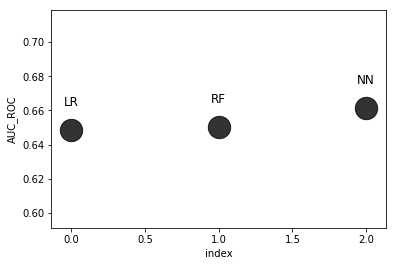

In [11]:
g=sns.regplot(data=model_summary, x="index", y="AUC_ROC", fit_reg=False,
               marker="o", color="black", scatter_kws={'s':500})
 
for i in range(0,model_summary.shape[0]):
     g.text(model_summary.loc[i,'index'], model_summary.loc[i,'AUC_ROC']+0.02, model_summary.loc[i,'Name'], 
            horizontalalignment='center',verticalalignment='top', size='large', color='black')

## **Model Interpretability Frameworks** <a id='interp'></a>
<br/> This section will cover the current popular frameworks for model explainability
<br/> Namely: LIME, ELI5, SHAP and SKATER
<br/> As you noticed in the [introduction](#intro), an infographics about diabetes was presented
<br/> Using the ML models we trained we will try to identify how each model decide based of the features
<br/> upon explaining the model we can also learn more about out features and its releationship to patient readmission

<br/> Here are the main techniques that will be presented for each framework
<br/> (This will be dependent to the availability of the technique in a framework)

- Feature Importance
- Permutation Importance
- Parital Dependency Plot
- Local Model Interpretation
- Global Model Interpretation


## **LIME** <a id='LIME'></a>
which stands for **Local Interpretable Model-Agnostic Explanation**
<br/> for more info here: [LIME: Explaining the predictions of any machine learning classifier](https://github.com/marcotcr/lime)

In [12]:
#initialization of a explainer from LIME
explainer = LimeTabularExplainer(X_train.values,
                                 mode='classification',
                                 feature_names=X_train.columns,
                                 class_names=['Readmitted','Not Readmitted'])

The LIME explainer is a Local Model Interpreter which include the feature importance for a particular prediction.
<br/> This is helpful if you want to findout why the model predicted this way in a particular patient.

![](http://)### LIME - Logistic Regression

We can see here that the acarbose and number of emergency were two of the deciding features for the prediction probabilities the patient.
We can also note in the Feature & value table the features that do not have a contirbution to the prediction colored in white.

In [13]:
exp = explainer.explain_instance(X_test.head(1).values[0],
                                 ML_models['LR'].predict_proba,
                                 num_features=X_train.shape[1])
exp.show_in_notebook(show_table=True, show_all=True)

### LIME - Random Forest

We can see here that the number of emergency and chlorpropamide were two of the deciding features for the prediction probabilities the patient.
We can also note in the Feature & value table the features that do not have a contirbution to the prediction colored in white.

In [14]:
exp = explainer.explain_instance(X_test.head(1).values[0],
                                 ML_models['RF'].predict_proba,
                                 num_features=X_train.shape[1])
exp.show_in_notebook(show_table=True, show_all=False)

### LIME - Neural Network

We can see here that the number of emergency and chlorpropamide were one of the deciding features for the prediction probabilities the patient.
We can also note in the Feature & value table the features that do not have a contirbution to the prediction colored in white.

In [15]:
exp = explainer.explain_instance(X_test.head(1).values[0],
                                 ML_models['NN'].predict_proba,
                                 num_features=X_train.shape[1])
exp.show_in_notebook(show_table=True, show_all=False)

## **ELI5** <a id='ELI5'></a>
It most likely originated from **Explain Like I'm 5** concept hence the framework name
<br/> more info here: [ELI5: A library for debugging/inspecting machine learning classifiers and explaining their predictions](https://github.com/TeamHG-Memex/eli5)

### ELI5 - Logistic Regression
- Global model interpretation
- Local model interpretation
- Permutation Importance from Testing Data

For the global model interpretation, we can notice that number of patient and diabetes(or not) are the two most positive contributing features.
While, the metformin-pioglitazone and other(health diagnosis) are the two most negative contributing features

In [16]:
eli5.show_weights(ML_models['LR'], feature_names = list(X_test.columns))

For the local model interpretation, we can notice that acetohexamide and glimepiride-pioglitazone are the two most positive contributing features.
While, the metformin-pioglitazone and tolbutamide are the two most negative contributing features

In [17]:
eli5.show_prediction(ML_models['LR'], X_test.head(1).values[0],feature_names=list(X_test.columns))

For the permutation importance, we can notice that number_inpatient and number_emergency are the two most positive contributing features.

In [18]:
exp = PermutationImportance(ML_models['LR'],
                            random_state = 0).fit(X_test, y_test)
eli5.show_weights(exp,feature_names=list(X_test.columns))

### ELI5 - Random Forest
- Global model interpretation
- Local model interpretation
- Permutation Importance from Testing Data

For the global model interpretation, we can notice that num_lab_procedures and num_medications are the two most positive contributing features.

In [19]:
eli5.show_weights(ML_models['RF'],feature_names=list(X_test.columns))

For the local model interpretation, we can notice that number_diagnoses and diabetesMed are the two most positive contributing features.
While, the number_inpatient and age are the two most negative contributing features

In [20]:
eli5.show_prediction(ML_models['RF'], X_test.head(1).values[0],feature_names=list(X_test.columns))

For the permutation importance, we can notice that number_inpatient and number_emergency are the two most positive contributing features.

In [21]:
exp = PermutationImportance(ML_models['RF'],
                            random_state = 0).fit(X_test, y_test)
eli5.show_weights(exp,feature_names=list(X_test.columns))

### ELI5 - Neural Network
Unfortunately, there is no support yet for Sklearn Neural Net for ELI5 Explainers

In [22]:
eli5.show_weights(ML_models['NN'])

## **SHAP** <a id='SHAP'></a>
which stands for **SHapley Additive exPlanations**
<br/> more info here: [SHAP: A unified approach to explain the output of any machine learning model](https://github.com/slundberg/shap)

### SHAP - Logistic Regression
- Local model interpretation
- Interative local model interpretations visualization
- Global model interpretation
- Partial dependency plot

For the local model interpretation, we can notice that number_diagnosis and diabetesMed are the two most positive contributing features.
While, the number_inpatient and diabetes(or not) are the two most negative contributing features

In [23]:
explainer = LinearExplainer(ML_models['LR'], X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test.head(1).values)
shap.force_plot(explainer.expected_value,
                shap_values,
                X_test.head(1).values,
                feature_names=X_test.columns)

In [24]:
shap_values = explainer.shap_values(X_test.head(250).values)
shap.force_plot(explainer.expected_value,
                shap_values,
                X_test.head(250).values,
                feature_names=X_test.columns)

For the global model interpretation, we can notice that number_inpatient and number_diagnoses are the two most contributing features.

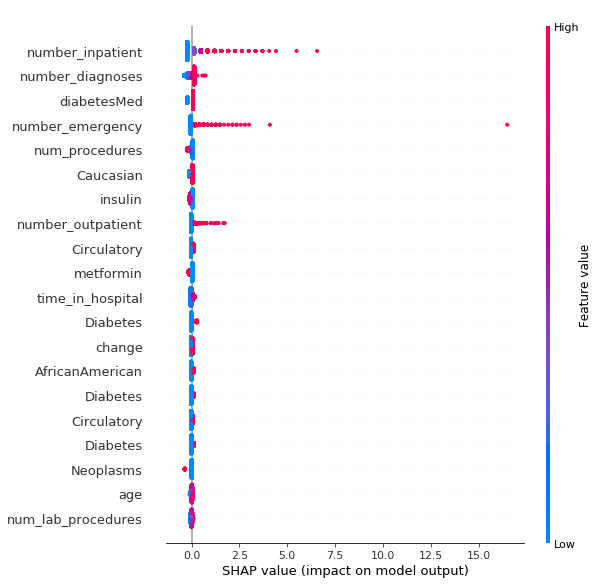

In [25]:
shap_values = explainer.shap_values(X_test.values)
spplot = shap.summary_plot(shap_values, X_test.values, feature_names=X_test.columns)

We will be creating dependence plot for the top 4 important features based on the model.
<br/> This will show how different values of the feature affects the decision of the model

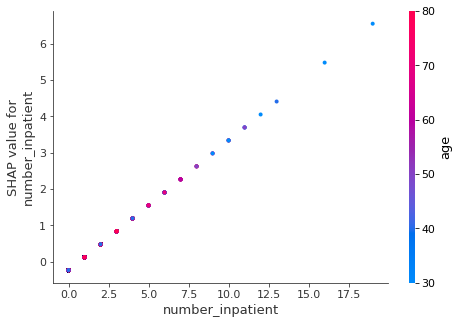

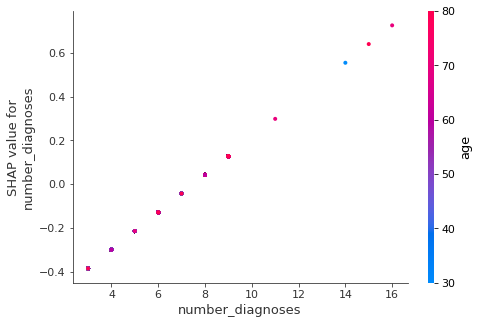

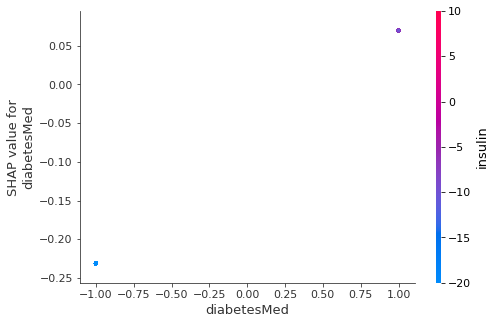

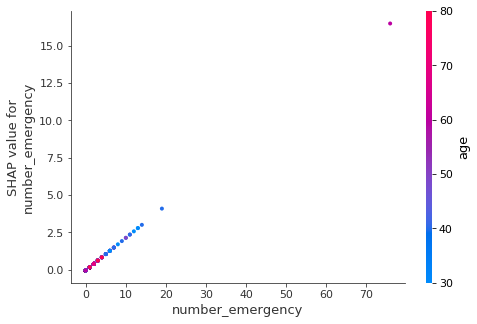

In [26]:
top4_cols = ['number_inpatient','number_diagnoses','diabetesMed','number_emergency']
for col in top4_cols:
    shap.dependence_plot(col, shap_values, X_test)

I tried running all the X_test for the explainer and it never finished in the kaggle kernel.
You can try it out in your machine but for the mean time, I will only show the Local interpretation for random forest and neural network

### SHAP - Random Forest
- Local model interpretation

For the local model interpretation, we can notice that number_diagnosis and diabetesMed are the two most positive contributing features.
While, the number_inpatient and diabetes(or not) are the two most negative contributing features

In [27]:
explainer = TreeExplainer(ML_models['RF'])
shap_values = explainer.shap_values(X_test.head(1).values)
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                X_test.head(1).values,
                feature_names=X_test.columns)

Unfortunately There is still no support for Sklearn Neural Net for SHAP DeepExplainers.
<br/>I also tried running all the X_test for the KernelExplainer but it never finisheed. One suggested solution is to use shap.kmeans
Note: If you have other fix on how to speed up Shap explainers, please comment you ideas. Thank you in advance for the insght

### SHAP - Neural Network
- Local model interpretation

For the local model interpretation, we can notice that number_diagnosis and diabetesMed are the two most positive contributing features.
While, the insulin and diabetes(or not) are the two most negative contributing features

In [28]:
X_train_kmeans = shap.kmeans(X_train, 10)
explainer = KernelExplainer(ML_models['NN'].predict_proba,X_train_kmeans)
shap_values = explainer.shap_values(X_test.head(1).values)
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                X_test.head(1).values,
                feature_names=X_test.columns)

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


# SKATER
I tried researching if the name stands for something.. but I guess its really just SKATER :))
<br/> Feel free to comment below if you know why this framework is called SKATER
<br/> more info here: [SKATER: Python Library for Model Interpretation/Explanations](https://github.com/datascienceinc/Skater)

### SKATER - Logistic Regression
- Global model interpretation
- Partial dependency plot

For the global model interpretation, we can notice that number_inpatient and num_diagnoses are two of the most important features.

[70/70] features ████████████████████ Time elapsed: 4 seconds

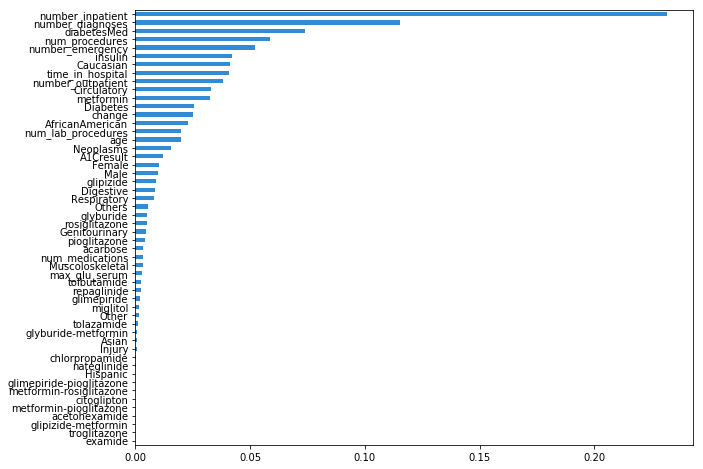

In [29]:
interpreter = Interpretation(X_test.values,feature_names=X_test.columns)
model = InMemoryModel(ML_models['LR'].predict_proba, examples=X_test.values)
fig,ax=plt.subplots(figsize=(10,8))
interpreter.feature_importance.plot_feature_importance(model, ascending=False,ax=ax);

We will be creating partial dependence plot for the top 4 important features based on the model.
<br/> This will show how different values of the feature affects the decision of the model

[7/7] grid cells ████████████████████ Time elapsed: 0 seconds

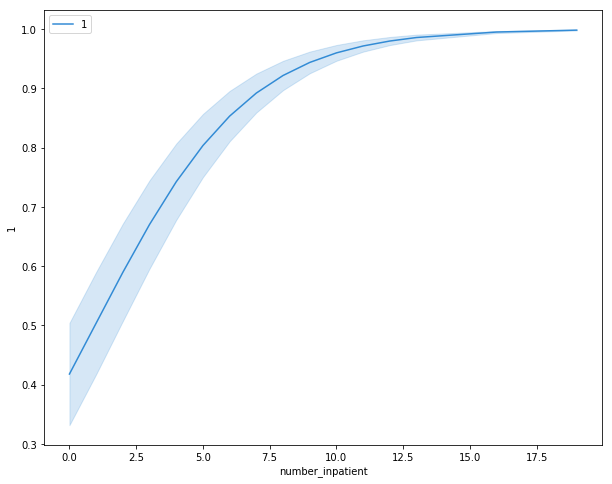

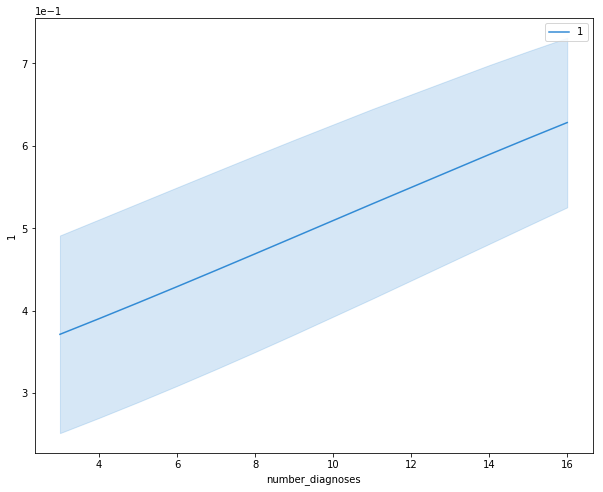

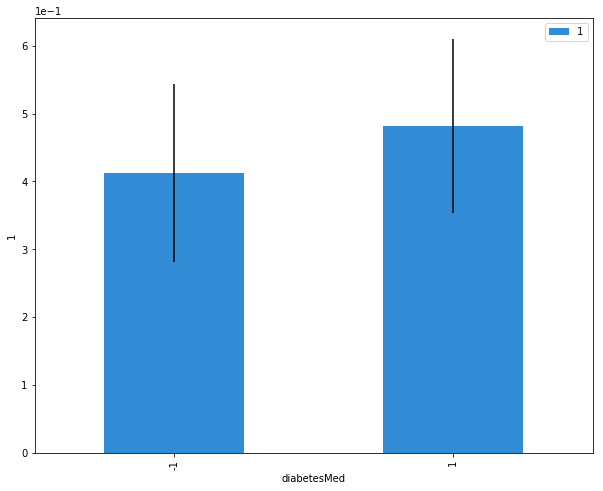

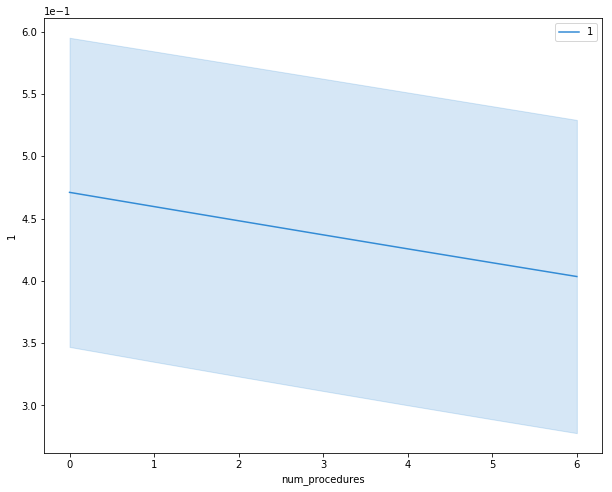

In [30]:
imp_cols = interpreter.feature_importance.feature_importance(model, ascending=False)
for col in imp_cols[:4].index.tolist():
    interpreter.partial_dependence.plot_partial_dependence([col],
                                                           model,grid_resolution=30,
                                                           with_variance=True,
                                                           figsize=(10,8))

### SKATER - Random Forest
- Global model interpretation
- Partial dependency plot

For the global model interpretation, we can notice that number_inpatient and num_medications are two of the most important features.

[70/70] features ████████████████████ Time elapsed: 22 seconds

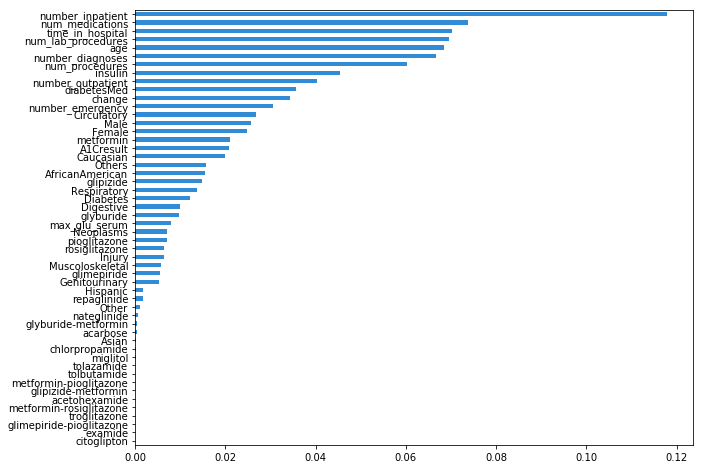

In [31]:
interpreter = Interpretation(X_test.values, feature_names=X_test.columns)
model = InMemoryModel(ML_models['RF'].predict_proba, examples=X_test.values)
fig,ax=plt.subplots(figsize=(10,8))
interpreter.feature_importance.plot_feature_importance(model, ascending=False,ax=ax);

We will be creating partial dependence plot for the top 4 important features based on the model.
<br/> This will show how different values of the feature affects the decision of the model

[30/30] grid cells ████████████████████ Time elapsed: 12 seconds

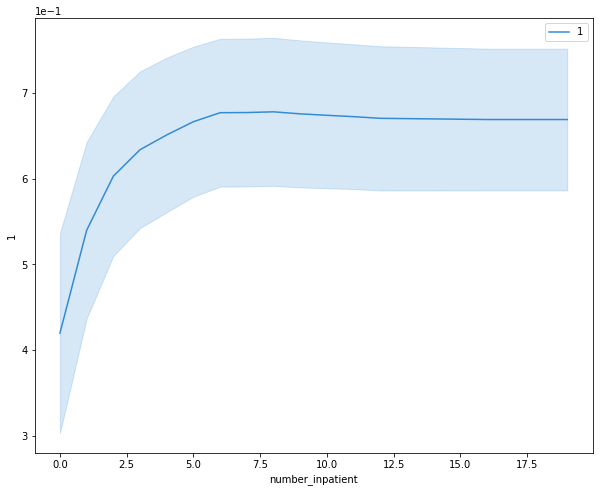

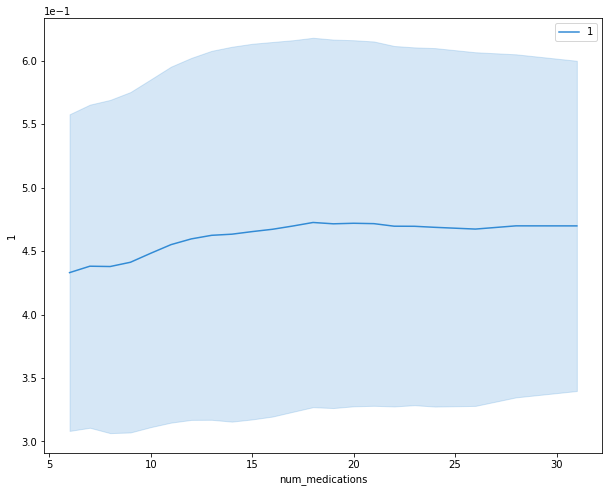

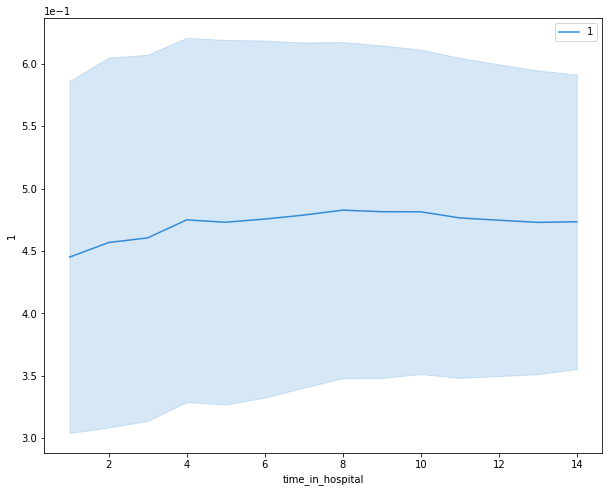

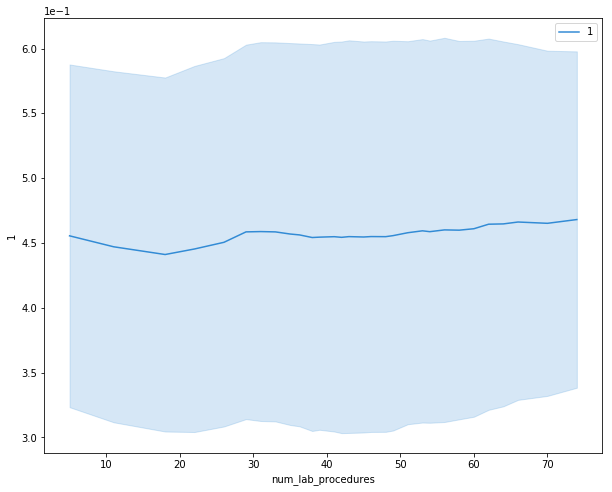

In [32]:
imp_cols = interpreter.feature_importance.feature_importance(model, ascending=False)
for col in imp_cols[:4].index.tolist():
    interpreter.partial_dependence.plot_partial_dependence([col],
                                                           model,grid_resolution=30,
                                                           with_variance=True,
                                                           figsize=(10,8))

### SKATER - Neural Network
- Global model interpretation
- Partial dependency plot

For the global model interpretation, we can notice that number_inpatient and age are two of the most important features.

[70/70] features ████████████████████ Time elapsed: 6 seconds

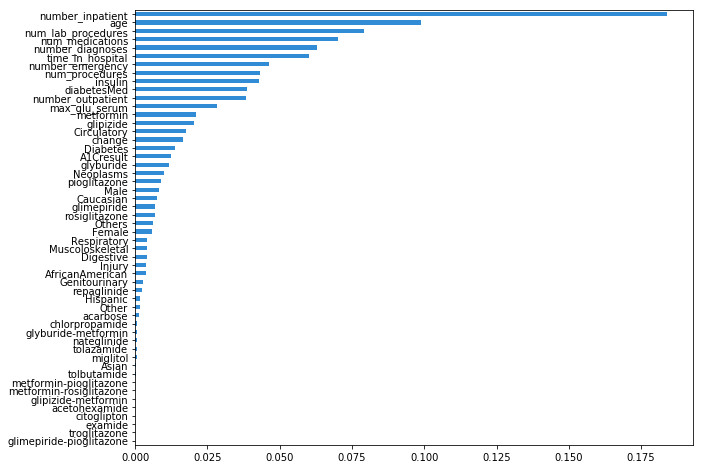

In [33]:
interpreter = Interpretation(X_test.values, feature_names=X_test.columns)
model = InMemoryModel(ML_models['NN'].predict_proba, examples=X_test.values)
fig,ax=plt.subplots(figsize=(10,8))
interpreter.feature_importance.plot_feature_importance(model, ascending=False,ax=ax);

We will be creating partial dependence plot for the top 4 important features based on the model.
<br/> This will show how different values of the feature affects the decision of the model

[22/22] grid cells ████████████████████ Time elapsed: 0 seconds

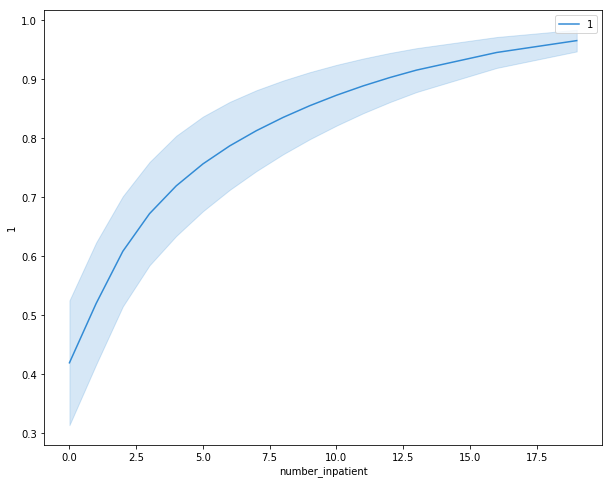

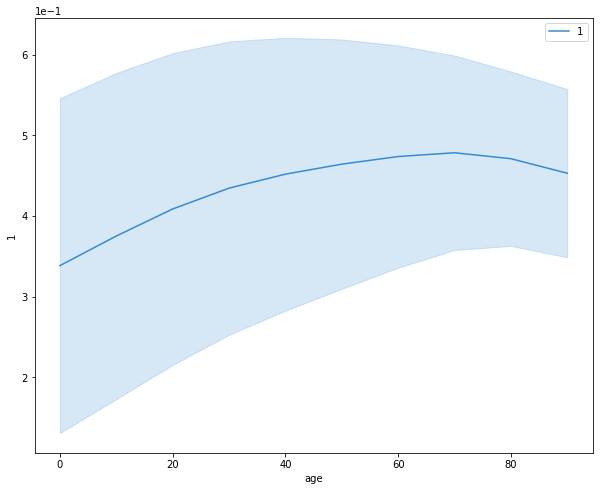

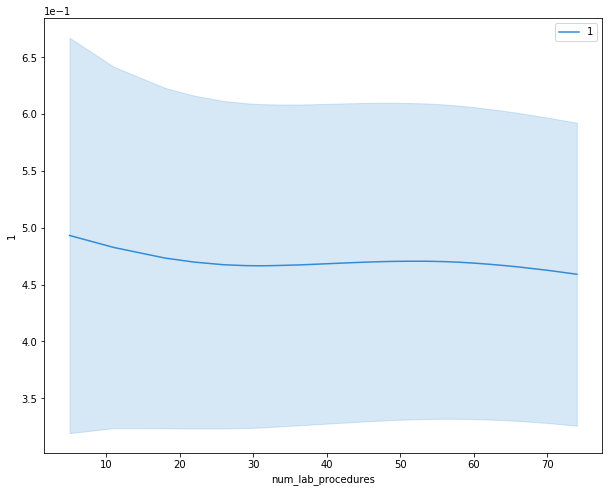

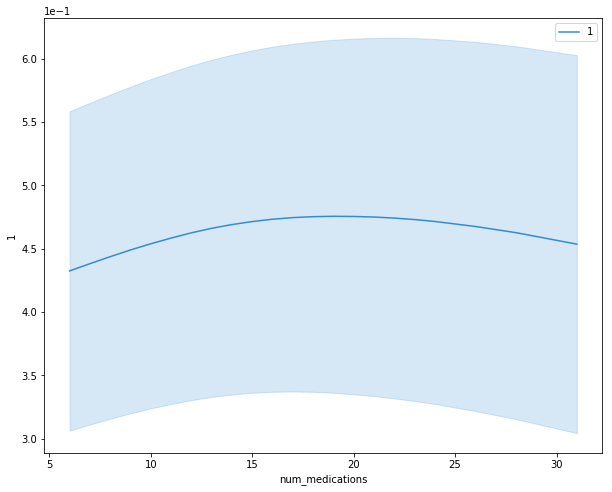

In [34]:
imp_cols = interpreter.feature_importance.feature_importance(model, ascending=False)
for col in imp_cols[:4].index.tolist():
    interpreter.partial_dependence.plot_partial_dependence([col],
                                                           model,grid_resolution=30,
                                                           with_variance=True,
                                                           figsize=(10,8))

# Summary <a id='summ'></a>
This section will cover what insights from each model and each framwork can be used for further research on patient readmission. We will also compare the 4 frameworks and the 3 ML models used in this kernel

**What the models learn and what do we learned?**

This table shows the most important feature of a model on a framework 

- Global interpretation Important features (using dibetes dataset)

| Framework        | Logistic Regression           | Random Forest  | Neural Network|
| ------------- |:-------------:| -----:|----:|
| LIME      | - | -  | - |
| ELI5      | number_inpatient      | num_lab_procedures  | - |
| SHAP |number_inpatient    |   - | -|
| SKATER | number_inpatient      |   number_inpatient | number_inpatient|

- Local interpretation Important features (for a sample patient in the testing set)

| Framework        | Logistic Regression           | Random Forest  | Neural Network|
| ------------- |:-------------:| -----:|----:|
| LIME      | number_emergency | number_emergency  | number_emergency |
| ELI5      | acetohexamide      |number_diagnoses  | - |
| SHAP | number_diagnoses    |   number_inpatient | diabeterMed|
| SKATER | *same w/ lime*      |   *same w/ lime* |  *same w/ lime*|
note: Skater local model interpretations were built on top of lime. 

Further research on the topic is needed to better undertand the results, but for a modeling prespective we can see that these possible important factors for patient readmission.


**4 Model Explainability Frameworks**

This table will summarize interpration capability, computation speed and learning curve for each framework.
Note. This will based on the experience from this kernel and from a kernel beginner perspective

| Framework        | Local Interpretation           | Global Interpretation  | Speed| Learning Curve |
| ------------- |:-------------:| -----:|----:| ----:|
| LIME      | Yes | - | Fast| Easy|
| ELI5      | Yes      |  Yes | Fast| Intermediate|
| SHAP | Yes    |   Yes | Slow| Intermediate|
| SKATER | Yes      |   Yes | Fast| Easy|

- LIME can only do Local Interpretation so we need to try other frameworks to get a global model interpretation
- SHAP can be slow on larger dataset (If you know a fix comment below). For this dataset I only do a sample for TreeExplainer and KernelExplainer since it never finished when I give it the whole dataset.
- ELI5 vs SKATER, they only differ in the number of techniques you can use.

**Modeling Observations**
<br/> This kernel focused on model explainability but for the model results we can see that the more complex a model there is an increase in the accuracy.

| Model        | F1-score           | AUCROC  | Interpretabiity|
| ------------- |:-------------:| -----:|----:|
| Logistic Regression      | 0.597870 | 0.648635| Easy|
| Random Forest      | 0.605973      |  0.650529 | Intermediate|
| Neural Network | 0.613643    |   0.661320 | Difficult|

- Logistic regression, even without the model explainer frameworks we can interpret the regression coefficient interm of their sign and magnitude.
- Random forest, decision trees are easier to interpret since we just follow the rules it learn to get the reason for a prediction. However for a random forest there will be multiple trees. Without using a framework we can get the feature importance.
- Neural Nets, basically a few years a ago labeled as a blackbox model due to its complexity. It is very difficult to explain why neural nets get the predictions but they get it with outstanding accuracy. The best way to interpter the NN model is to use one of the frameworks.


# Key Takeaways <a id='conc'></a>

Data science is a very wide and interdesciplinary field. But we should not be afraid of the Danger zones.
<br/>We now have model explainer frameworks that can help us understand better how our model make decisions.
![](https://cdn-images-1.medium.com/max/1600/1*WvOnZ27TdPUbJfa9q21QJw.png)

## **Thank you for reading until the end**
<br/> *If you learned something from this kernel*   ** Please Upvote**

This is an official entry for the [Kernel Author of the Month (February)](https://www.kaggle.com/page/Kernel-Author-of-the-Month?utm_medium=social&utm_source=hootsuite&utm_campaign=Kernel-Author-of-the-Month)


Notes: This kernel will be further be improved and revised even after the month of feb.
<br/>I had a lot of fun exploring how to explain machine learning models and I want to make this kernel a great resource for model explainability.

**References**

Kaggle Kernels

- [Machine Learning Explainability by Dan Becker](https://www.kaggle.com/learn/machine-learning-explainability)

Online Articles
- [A Brief History of Machine Learning Models Explainability](https://medium.com/@Zelros/a-brief-history-of- machine-learning-models-explainability-f1c3301be9dc)
- [Interpreting Machine Learning Models](https://medium.com/ansaro-blog/interpreting-machine-learning-models-1234d735d6c9)
- [Interpretability vs. Accuracy: The Friction that Defines Deep Learning](https://towardsdatascience.com/interpretability-vs-accuracy-the-friction-that-defines-deep-learning-dae16c84db5c)